# **Data Description:**
You are provided with a dataset of images of plant seedlings at various stages of grown. Each image has a filename that is its unique id. The dataset comprises 12 plant species. The goal of the project is to create a classifier capable of determining a plant's species from a photo.
# **Dataset:**
The dataset can be download from Olympus. The data file names are:
 images.npy
 Label.csv
The original files are from Kaggle. Due to the large volume of data, the images were converted to images.npy file and the labels are also put into the Labels.csv. So that you can work on the data/project seamlessly without worrying about the high data volume.


## 1. Import the libraries, load dataset, print shape of data, visualize the images in dataset. 


In [ ]:
#import all the necessary libraries.
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D
from tensorflow.keras.models import Sequential
from keras.layers.core import Activation, Flatten, Dense
from keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix,multilabel_confusion_matrix
from tensorflow.keras import datasets, models, layers, optimizers

## Load and view the dataset (from the 2 files)
- images.npy : contains all the images
- Labels.csv : contains all the relevant labels for the images


In [ ]:
# Mount the drive and read images.npy and Labels.csv file from the drive location.
from google.colab import drive,files
drive.mount('/content/drive')
image_path='/content/drive/My Drive/Colab Notebooks/CNN/Project 7/images.npy'
label_path='/content/drive/My Drive/Colab Notebooks/CNN/Project 7/Labels.csv'
images = np.load(image_path)
label = pd.read_csv(label_path)

Mounted at /content/drive


In [ ]:
#Look at the data type and shapes of the images and labels.
print("image type:", type(images))
print("image shape:", images.shape)
print("label type",type(label))
print("label shape",label.shape)
print("image 0 type",images[0].shape)
print("image 0 type",images[0].dtype)

image type: <class 'numpy.ndarray'>
image shape: (4750, 128, 128, 3)
label type <class 'pandas.core.frame.DataFrame'>
label shape (4750, 1)
image 0 type (128, 128, 3)
image 0 type uint8


- We can see that there are 4750 images and corresponding labels.
- the images are color images with 128x128x3 (3 corresponding to color and 128 x 128 pixels)

## Visualization of images

,Label
3,Small-flowered Cranesbill


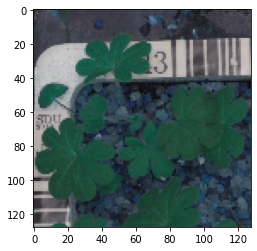

In [ ]:
# Displaying the image at a specific location and also look at the label at that particular location.
plt.imshow(images[3])
label.iloc[['3']]

- We can see that the Label at location 3 is Small-flowered Cranesbill

## 2. Data Pre-processing:
- a. Gaussian Blurring.
- b. Visualize data after pre-processing

In [ ]:
# Function to display one image
def display_one(a, title1 = "Original"):
    plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.show()
# Function to display two images
def display(a, b, title1, title2):
    plt.subplot(121), plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()

### Gaussian Blurring

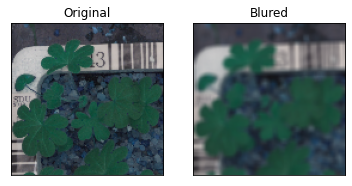

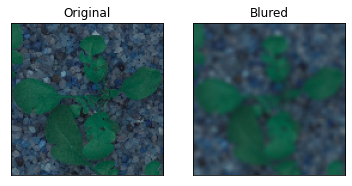

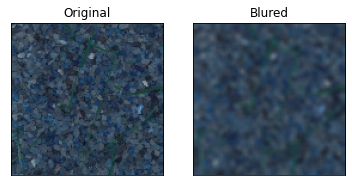

In [ ]:
# Remove noise - Gaussian Blur
# Iterate through all images and perform gaussian blur on the images and strore it on new_images
new_images = np.empty(images.shape,dtype='uint8')

for i in range(len(images)):
    new_images[i] = cv2.GaussianBlur(images[i], (5, 5), 3,3)

#Displaying the original image and blurred image at location 3,1000,4749
display(images[3], new_images[3], 'Original', 'Blured')
display(images[1000], new_images[1000], 'Original', 'Blured')
display(images[4749], new_images[4749], 'Original', 'Blured')

- Displaying the original image at location 3, 1000 and 4749

### Extracting the image without background
- Use gaussian blur for remove noise
- Convert color to HSV
- Create mask
- Create boolean mask
- Apply boolean mask and getting image whithout background

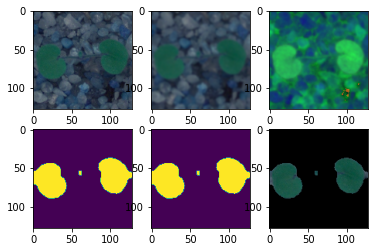

In [ ]:
clearTrainImg = []
examples = []; getEx = True
for img in images:
    # Use gaussian blur
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    
    # Convert to HSV image
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
    
    # Create mask (parameters - green color range)
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Create bool mask
    bMask = mask > 0  
    
    # Apply the mask
    clear = np.zeros_like(img, np.uint8)  # Create empty image
    clear[bMask] = img[bMask]  # Apply boolean mask to the origin image
    
    clearTrainImg.append(clear)  # Append image without backgroung
    
    # Show examples
    if getEx:
        plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
        plt.subplot(2, 3, 2); plt.imshow(blurImg)  # Blur image
        plt.subplot(2, 3, 3); plt.imshow(hsvImg)  # HSV image
        plt.subplot(2, 3, 4); plt.imshow(mask)  # Mask
        plt.subplot(2, 3, 5); plt.imshow(bMask)  # Boolean mask
        plt.subplot(2, 3, 6); plt.imshow(clear)  # Image without background
        getEx = False

clearTrainImg = np.asarray(clearTrainImg)

- Displaying the image without background

# Look at the Target Variable (Label)



In [ ]:
label['Label'].nunique()

12

- There are 12 unique values in the output variable. 

In [ ]:
# Finding out the number of images under each section of the image.
label['Label'].value_counts()

Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Maize                        221
Common wheat                 221
Name: Label, dtype: int64

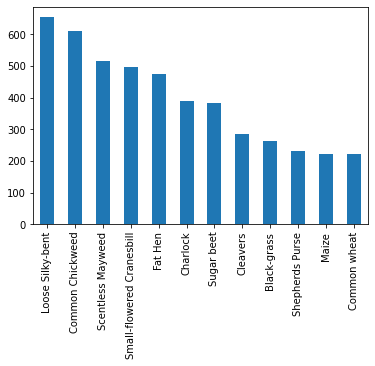

In [ ]:
#bar plot of the value counts on the target
label['Label'].value_counts().plot(kind='bar')

- Distribution of each of the output variables.

### Look at Pixel Intensity

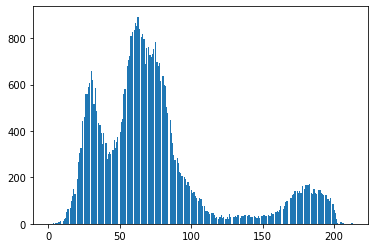

In [ ]:
# Draw the pixel intensity as a histogram for the original and after Gaussian blur
#hist,bins = np.histogram(images[3].ravel(),256,[0,256])
#plt.bar(bins[:-1] - 0.5, hist, width=1, edgecolor='none')
ax = plt.hist(images[3].ravel(), bins=256)
plt.show()

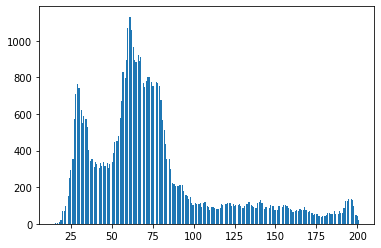

In [ ]:
#hist,bins = np.histogram(new_images[3].ravel(),256,[0,256])
#plt.bar(bins[:-1] - 0.5, hist, width=1, edgecolor='none')
ax = plt.hist(new_images[3].ravel(), bins=256)
plt.show()

- Pixel Intensity plot for the actual image and after the Glaussian Blur.

### 3. Make data compatible:
- a. Convert labels to one-hot-vectors.
- b. Print the label for y_train[0].
- c. Split the dataset into training, testing, and validation set.
(Hint: First split images and labels into training and testing set with test_size = 0.3. Then further split test data into test and validation set with test_size = 0.5)
- d. Check the shape of data, Reshape data into shapes compatible with Keras models if it’s not already. If it’s already in the compatible shape, then comment in the notebook that it’s already in compatible shape.

In [ ]:
#Assigning the labels to numbers before doing a hot encode 
labels = { "Black-grass":0,"Charlock":1,"Cleavers":2,"Common Chickweed":3,"Common wheat":4,"Fat Hen":5,"Loose Silky-bent":6,"Maize":7,
"Scentless Mayweed":8,"Shepherds Purse":9,"Small-flowered Cranesbill" :10,"Sugar beet":11}
y=label['Label']
y = y.map(labels)

- Split dataset
Split data on training and validation set. 30% of data became the validation set. Our data is unbalanced, so for avoiding inaccurate evaluation of model set stratify=y

In [ ]:
# Splitting data into training and test set:
X_train, X_test_initial, y_train, y_test_initial = train_test_split(new_images, y, test_size = 0.3, random_state = 7,stratify = y)
print(X_train.shape, X_test_initial.shape,y_train.shape,y_test_initial.shape)
#Split Data between test and validation
X_val,X_test,y_val,y_test=train_test_split(X_test_initial,y_test_initial,test_size=0.5)
print(X_val.shape, X_test.shape,y_val.shape,y_test.shape)

(3325, 128, 128, 3) (1425, 128, 128, 3) (3325,) (1425,)
(712, 128, 128, 3) (713, 128, 128, 3) (712,) (713,)


- Normalize the data before we run the model

In [ ]:
# Normalize the data
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_val /= 255
X_test /= 255

In [ ]:
#print the shpae of training validation and test set (input parameters/images)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(3325, 128, 128, 3)
(712, 128, 128, 3)
(713, 128, 128, 3)


In [ ]:
# Make labels categorical and print the shape and value of the encoded training, validation and test data of the output variable.
y_train = to_categorical(y_train, num_classes=12)
y_val = to_categorical(y_val, num_classes=12)
y_test = to_categorical(y_test, num_classes=12)

print("Shape of y_train:", y_train.shape)
print("One value of y_train:", y_train[0])
print("Shape of y_val:", y_val.shape)
print("One value of y_val:", y_val[0])
print("Shape of y_test:", y_test.shape)
print("One value of y_test:", y_test[0])

Shape of y_train: (3325, 12)
One value of y_train: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Shape of y_val: (712, 12)
One value of y_val: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Shape of y_test: (713, 12)
One value of y_test: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


- We can see how the data is split between train (3325 records), validation(712 records) and test(713 records).
- The shape of the compatible, so we don't need to reshape it.

### 4. Building CNN
- a. Define layers.
- b. Set optimizer and loss function. (Use Adam optimizer and categorical crossentropy.)

- Create the Model:
Convolutional input layer, 32 feature maps with a size of 5×5 and a rectifier activation function.
- Batch Normalization Layer.
Convolutional layer, 32 feature maps with a size of 5×5 and a rectifier activation function.
- Batch Normalization layer.
- Max Pool layer with size 2×2.
- Dropout layer at 25%.
- Convolutional layer, 64 feature maps with a size of 3×3 and a rectifier activation function.
- Batch Normalization layer.
- Dropout layer at 25%.
- Convolutional layer, 64 feature maps with a size of 3×3 and a rectifier activation function.
- Batch Normalization layer.
- Max Pool layer with size 2×2.
- Dropout layer at 25%.
- GlobalMaxPooling2D layer.
Fully connected layer with 256 units and a rectifier activation function.
- Dropout layer at 50%.
Fully connected output layer with 10 units and a softmax activation function.

In [ ]:
# creating the model with various convolution layers and finally creating a dense layer
model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), padding='same', activation="relu", input_shape=X_train.shape[1:]))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (5, 5), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(12, activation="softmax"))

model.summary()
   


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0

In [ ]:
# initiate Adam optimizer
opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

In [ ]:
# Let's compile/train the model using the below loss and optizers.
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
#Adding Early stopping callback to the fit function is going to stop the training,
#if the val_loss is not going to change even '0.001' for more than 10 continous epochs
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)
model_checkpoint =  ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/CNN/Project 7/',monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=True,mode='auto',period=1)

### 5. Fit and evaluate model and print confusion matrix.

In [ ]:
# Fit the model
#We can fit this model with 200 epochs and a batch size of 32.
history1 = model.fit(X_train,
                    y_train,
                    batch_size=32,
                    epochs=200,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    verbose=1,
                    callbacks=[early_stopping,model_checkpoint])

Epoch 1/200
104/104 [==============================] - 36s 36ms/step - loss: 3.2796 - accuracy: 0.2033 - val_loss: 2.5171 - val_accuracy: 0.0478

Epoch 00001: val_loss improved from inf to 2.51709, saving model to /content/drive/My Drive/Colab Notebooks/CNN/Project 7/
Epoch 2/200
104/104 [==============================] - 3s 28ms/step - loss: 1.8537 - accuracy: 0.3642 - val_loss: 2.6494 - val_accuracy: 0.1376

Epoch 00002: val_loss did not improve from 2.51709
Epoch 3/200
104/104 [==============================] - 3s 28ms/step - loss: 1.6159 - accuracy: 0.4379 - val_loss: 2.8275 - val_accuracy: 0.0857

Epoch 00003: val_loss did not improve from 2.51709
Epoch 4/200
104/104 [==============================] - 3s 28ms/step - loss: 1.4944 - accuracy: 0.4854 - val_loss: 2.2939 - val_accuracy: 0.1531

Epoch 00004: val_loss improved from 2.51709 to 2.29385, saving model to /content/drive/My Drive/Colab Notebooks/CNN/Project 7/
Epoch 5/200
104/104 [==============================] - 3s 28ms/step

In [ ]:
#function to plot the graph for Training and Validation accuracy
def plot_hist(cnn_model):
    plt.plot(cnn_model.history["accuracy"],label="Training")
    plt.plot(cnn_model.history["val_accuracy"],label="Validation")
    plt.title("Model training and validation accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(loc="upper left")
    plt.show()

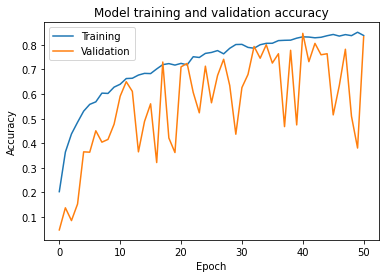

In [ ]:
#plotting the graph for Training and validation accuracy.
plot_hist(history1)

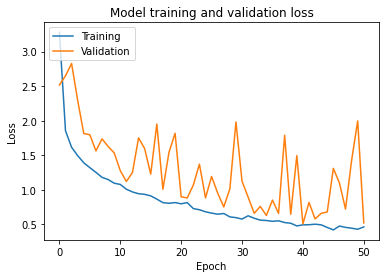

In [ ]:
#function for plotting graph for training and validation loss 
def plot_hist_loss(cnn_model):
    plt.plot(cnn_model.history["loss"],label="Training")
    plt.plot(cnn_model.history["val_loss"],label="Validation")
    plt.title("Model training and validation loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(loc="upper left")
    plt.show()
#plotting the graph for training and validation loss.
plot_hist_loss(history1)

In [ ]:
#print the test loss and test accuracy of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

23/23 [==============================] - 0s 18ms/step - loss: 0.4806 - accuracy: 0.8696
Test loss: 0.4806002378463745
Test accuracy: 0.8695651888847351


In [ ]:
#Predict the values of the actual predicted value based on argmax function.
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=-1)

In [ ]:
#print the values of y_test values of a few records.
y_test = np.argmax(y_test,axis=1)
print(y_test[0],y_test[2],y_test[32])

3 1 3


In [ ]:
#List down all the class names, in order to print the confusion matrix with the label names.
class_names = ["Black-grass","Charlock","Cleavers","Common Chickweed","Common wheat","Fat Hen","Loose Silky-bent","Maize","Scentless Mayweed","Shepherds Purse",
               "Small-flowered Cranesbill","Sugar beet"]

=== Confusion Matrix ===


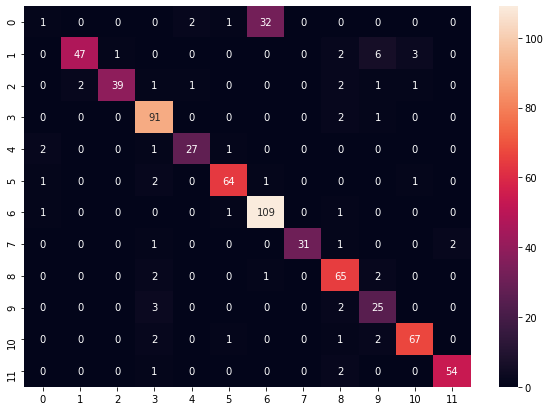

In [ ]:
#print the confusion matrix
print("=== Confusion Matrix ===")
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='d')

<Figure size 432x288 with 0 Axes>

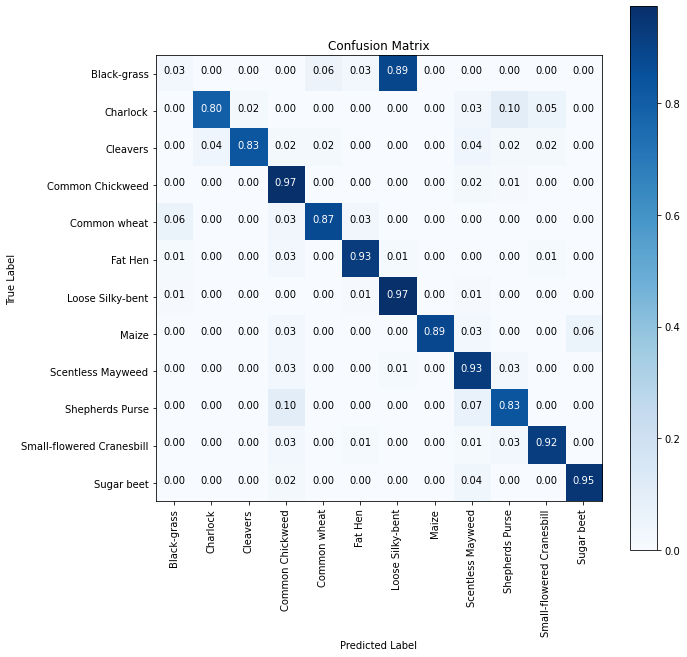

In [ ]:
#function for plotting confusion matrix by converting the label numbers to label description
import itertools

def plot_confusion_matrix(cm,classes,title='Confusion Matrix',cmap=plt.cm.Blues):
    
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f'
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass

cnf_mat = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)


plt.figure()
plot_confusion_matrix(cnf_mat,classes=class_names)
plt.show()

In [ ]:
print("=== Classification Report ===")
target_names = ["Class {}".format(i) for i in range(12)]
print(classification_report(y_test, y_pred, target_names=target_names))

=== Classification Report ===
              precision    recall  f1-score   support

     Class 0       0.20      0.03      0.05        36
     Class 1       0.96      0.80      0.87        59
     Class 2       0.97      0.83      0.90        47
     Class 3       0.88      0.97      0.92        94
     Class 4       0.90      0.87      0.89        31
     Class 5       0.94      0.93      0.93        69
     Class 6       0.76      0.97      0.85       112
     Class 7       1.00      0.89      0.94        35
     Class 8       0.83      0.93      0.88        70
     Class 9       0.68      0.83      0.75        30
    Class 10       0.93      0.92      0.92        73
    Class 11       0.96      0.95      0.96        57

    accuracy                           0.87       713
   macro avg       0.83      0.83      0.82       713
weighted avg       0.85      0.87      0.85       713



In [ ]:
#inverse dictionary for the labels in order to print the label names.
labels = { "Black-grass":0,"Charlock":1,"Cleavers":2,"Common Chickweed":3,"Common wheat":4,"Fat Hen":5,"Loose Silky-bent":6,"Maize":7,
"Scentless Mayweed":8,"Shepherds Purse":9,"Small-flowered Cranesbill" :10,"Sugar beet":11}

In [ ]:
#Function to get the keys from the value
def get_keys_from_value(d, val):
    return [k for k, v in d.items() if v == val]

Found correct labels 620


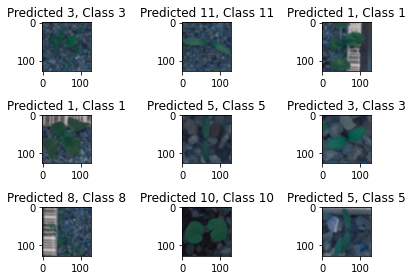

In [ ]:
#Determine the number of correct predictions from test set and print a few correct ones.
correct = np.where(y_pred==y_test)[0]
print("Found correct labels",len(correct))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct])
    plt.title("Predicted {}, Class {}".format(y_pred[correct], y_test[correct]))
    plt.tight_layout()

- We can see out of the 713 test values 620 are predicted correctly


Found incorrect labels 93


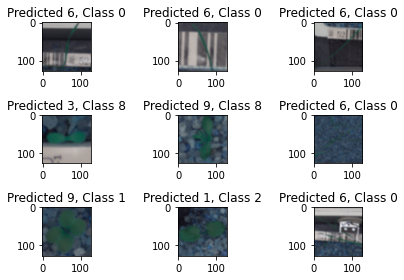

In [ ]:
#Determine the number of incorrect predictions from the test set and print a few incorrect ones
incorrect = np.where(y_pred!=y_test)[0]
print("Found incorrect labels",len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect])
    plt.title("Predicted {}, Class {}".format(y_pred[incorrect], y_test[incorrect]))
    plt.tight_layout()

- We can see out of the 713 test values 93 are predicted incorrectly


- 

### 6. Visualize predictions for x_test[2], x_test[3], x_test[33], x_test[36], x_test[59]

In [ ]:
#Visualize predictions for x_test[2], x_test[3], x_test[33], x_test[36], x_test[59]
list = [2, 3, 33, 36, 59]
for i in list: 
  print("Actual :", get_keys_from_value(labels,y_test[i]),"Predicted :",get_keys_from_value(labels,y_pred[i]))

Actual : ['Charlock'] Predicted : ['Charlock']
Actual : ['Charlock'] Predicted : ['Charlock']
Actual : ['Scentless Mayweed'] Predicted : ['Scentless Mayweed']
Actual : ['Sugar beet'] Predicted : ['Sugar beet']
Actual : ['Small-flowered Cranesbill'] Predicted : ['Small-flowered Cranesbill']


- We can see the predictions of image at location 2, 3, 33, 36, 59. 
- Out of this all 5 have been predicted successfully.

Text(0.5, 1.0, 'Predicted 10, Actual 10 for image 59')

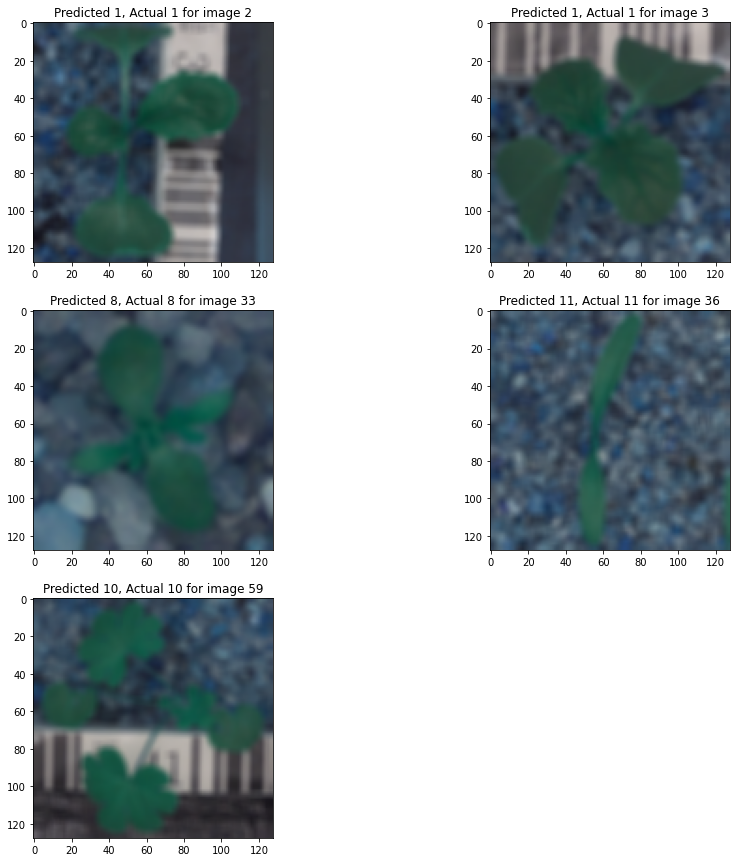

In [ ]:
# Plot all the actual and predicted values for the images at location 2,3,33,36 and 59.
# create figure
fig = plt.figure(figsize=(15, 15))
  
# setting values to rows and column variables
rows = 3
columns = 2

  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(X_test[2])
#title = "Actual :" + " " + str(get_keys_from_value(labels,y_test[2])) + " " + "Predicted : " + " " + str(get_keys_from_value(labels,y_pred[2]))
plt.title("Predicted {}, Actual {} for image 2".format(y_pred[2], y_test[2]))

  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(X_test[3])
#title = "Actual :" + " " + str(get_keys_from_value(labels,y_test[3])) + " " + "Predicted : " + " " + str(get_keys_from_value(labels,y_pred[3]))
plt.title("Predicted {}, Actual {} for image 3".format(y_pred[3], y_test[3]))

  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(X_test[33])
#title = "Actual :" + " " + str(get_keys_from_value(labels,y_test[33])) + " " + "Predicted : " + " " + str(get_keys_from_value(labels,y_pred[33]))
plt.title("Predicted {}, Actual {} for image 33".format(y_pred[33], y_test[33]))

  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(X_test[36])
#title = "Actual :" + " " + str(get_keys_from_value(labels,y_test[36])) + " " + "Predicted : " + " " + str(get_keys_from_value(labels,y_pred[36]))
plt.title("Predicted {}, Actual {} for image 36".format(y_pred[36], y_test[36]))

# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 5)
  
# showing image
plt.imshow(X_test[59])
#title = "Actual :" + " " + str(get_keys_from_value(labels,y_test[59])) + " " + "Predicted : " + " " + str(get_keys_from_value(labels,y_pred[59]))
plt.title("Predicted {}, Actual {} for image 59".format(y_pred[59], y_test[59]))


- We can see the visualizations and predictions of all the test images at each location
- Image X_test[2] : Actual : Charlock Predicted : Charlock
- Image X_test[3] : Actual : Charlock Predicted : Charlock
- Image X_test[33]: Actual : Scentless Mayweed Predicted : Scentless Mayweed
- Image X_test[36]: Actual : Sugar beet Predicted : Sugar beet
- Image X{test[59]: Actual : Small-flowered Cranesbill Predicted : Small-flowered Cranesbill

#Conclusion

- We built a model for a multi classification problem for image classification.
- The model was built with CNN and Dense Network and was able to predict the images with an accuracy of 86%
- We can see from the confusion matrix / classification report that the label 0 (Black grass) has the least accuracy and there are a lot of errors and they are predicted as label 6 (Loose Silky Bent)